# InceptionV3 fine-tuning
Since the performances of the network using *InceptionV3* as feature extractor were not enough satisfactory, now we try to push the performance a bit further by fine-tuning the best pre-trained model obtained with the feature-extraction approach.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PieTempesti98/CNNMalariaDetector/blob/master/CAM_visualization.ipynb)


In [ ]:
# imports
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as ks
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import *
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from IPython.core.display import Image
from tensorflow.keras.optimizers import SGD

In [ ]:
# global parameters
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256
SEED = 20

In [ ]:
# set always the same seed i order to obtain reproducible results
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# path settings and mount of google drive folders

PROJECT_DIR_PATH = "/content/gdrive/MyDrive/Colab Notebooks/cidl_project"
MODELS_DIR_PATH = "/models/"
IMAGES_DIR_PATH = PROJECT_DIR_PATH + "/images/"

# mount google drive
drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


## Dataset import and pre-processing
In this subsection we import the dataset and we peform some pre-processing operations over it.

In [ ]:
# load malaria dataset from Tensorflow and split it in train, test and validation
(train_ds, val_ds, test_ds), info = tfds.load(
    'malaria',
    as_supervised=True,
    split=['train[:80%]','train[80%:85%]', 'train[85%:]'],
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteYOVQ6Y/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


### Image rescaling
All the images are rescaled to a 299x299 size.

In [ ]:
# image rescaling
@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (299, 299)) # Resizing the image to 299x299
    return (image, label)

In [ ]:
# mapping of all the sets
train_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Model utils
The following function is used to evaluate the models.

### Model compile and train utils

In [ ]:
def compile_model (model, learning_rate):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param learning_rate: learning rate parameter for the optimizer
  '''
  # compile the model
  model.compile(
              optimizer=SGD(learning_rate=learning_rate, momentum=0.9), 
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
          )
  model.summary()
  return model

In [ ]:
def run_model (model, name):
  '''
  run_model is used to train the current model
  :param model: model to compile
  '''
  # define call-back for check-point
  check_point = ks.callbacks.ModelCheckpoint(
                          filepath = PROJECT_DIR_PATH + MODELS_DIR_PATH + name + '.h5',
                          monitor="val_loss",
                          verbose=1,
                          save_best_only=True)

  # call-back function for early termination
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  # train the model
  history = model.fit(train_ds, epochs=100, shuffle=True, validation_data=val_ds, callbacks = [stop_early, check_point])
  return history

### Evaluation utils

In [ ]:
# Model evaluation function
def evaluate_model (model, name):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  :param name: name of the model
  '''
  model = ks.models.load_model(PROJECT_DIR_PATH + MODELS_DIR_PATH + name + '.h5')
  y_score = model.predict(test_ds)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_ds], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
# Model train-test-evaluation  functions
def show_train_val_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## Fine-tuning
To fine-tune the network for our classification task, we are going to **unfreeze the last block** of *InceptionV3*'s architecture. To limit the magnitude of modification made to pre-trained model, we will use a small learning rate.

### Simple model
We load from models' directory the best model trained using *InceptionV3* as feature extractor, we unfreeze *InceptionV3*'s last layer and we re-train the network in such a way to boost the performances.

In [ ]:
# load the model
global_avg_model = models.load_model(os.path.join(PROJECT_DIR_PATH + MODELS_DIR_PATH, 'inceptionV3_feature_extraction_global_avg_model.h5'))

In [ ]:
# Enumerate model's InceptionV3's layers
for i, layer in enumerate(global_avg_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False


In [ ]:
for i, layer in enumerate(global_avg_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 tf.math.truediv True
2 tf.math.subtract True
3 inception_v3 True
4 global_average_pooling2d True
5 dense True
6 dropout True
7 dense_1 True


In [ ]:
# unfreeze InceptionV3's layers since now we perform fine-tuning
global_avg_model.trainable = True

# we chose to train the top 2 inception blocks, i.e. we freeze
# the first 249 layers and unfreeze the rest:
for layer in global_avg_model.get_layer('inception_v3').layers[:249]:
   layer.trainable = False
for layer in global_avg_model.get_layer('inception_v3').layers[249:]:
   layer.trainable = True


# Make sure you have frozen the correct layers
for i, layer in enumerate(global_avg_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# compile the model
global_avg_model = compile_model(global_avg_model, 0.00001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
# train the model
history = run_model(global_avg_model, 'inceptionV3_finetuning_global_avg_model')

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 1.5676 - binary_accuracy: 0.5378
Epoch 1: val_loss improved from inf to 0.65605, saving model to /content/gdrive/MyDrive/Colab Notebooks/cidl_project/models/inceptionV3_finetuning_global_avg_model.h5
87/87 [==============================] - 141s 1s/step - loss: 1.5676 - binary_accuracy: 0.5378 - val_loss: 0.6561 - val_binary_accuracy: 0.5080
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6562 - binary_accuracy: 0.6068
Epoch 2: val_loss did not improve from 0.65605
87/87 [==============================] - 101s 1s/step - loss: 0.6562 - binary_accuracy: 0.6068 - val_loss: 0.8876 - val_binary_accuracy: 0.5022
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6453 - binary_accuracy: 0.6207
Epoch 3: val_loss did not improve from 0.65605
87/87 [==============================] - 101s 1s/step - loss: 0.6453 - binary_accuracy: 0.6207 - val_loss: 0.7190 - val_binary_accuracy: 0.5501
E

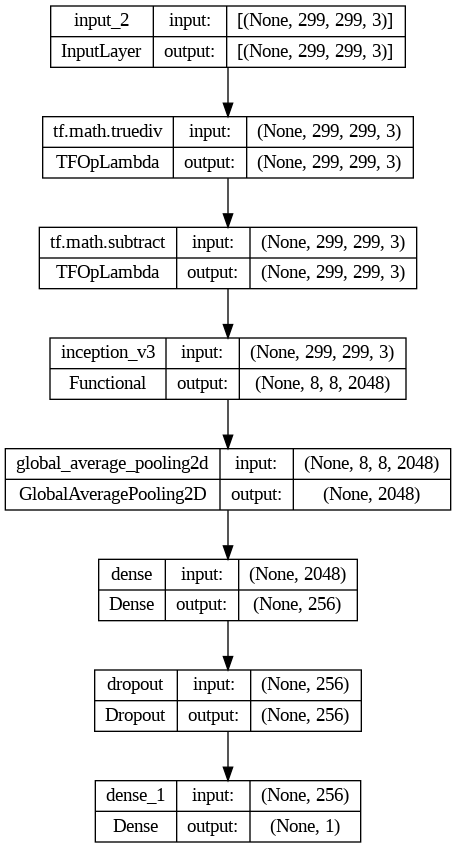

In [ ]:
# display model structure
plot_model(global_avg_model, 'inceptionV3_finetuning_global_avg_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_finetuning_global_avg_model.png"))
!cp -r './inceptionV3_finetuning_global_avg_model.png' IMAGES_DIR_PATH

17/17 [==============================] - 18s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7924    0.7522    0.7718      2086
           1     0.7600    0.7993    0.7792      2048

    accuracy                         0.7755      4134
   macro avg     0.7762    0.7757    0.7755      4134
weighted avg     0.7764    0.7755    0.7754      4134



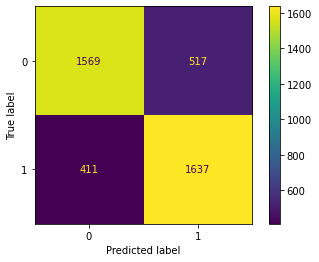

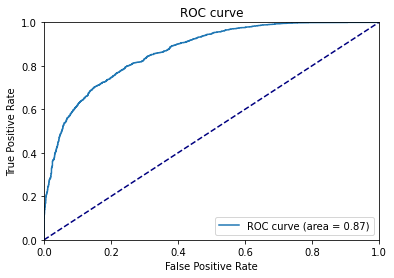

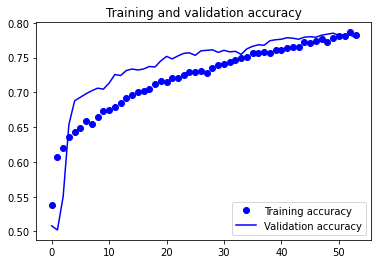

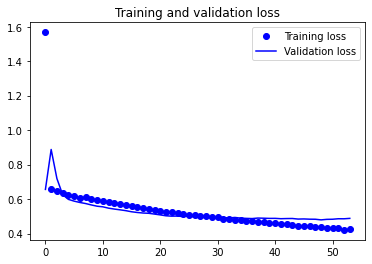

In [ ]:
# evaluate model
evaluate_model(global_avg_model, 'inceptionV3_finetuning_global_avg_model')
show_train_val_performance(history)

### Complex model

In [ ]:
# load the model
complex_model = models.load_model(os.path.join(PROJECT_DIR_PATH + MODELS_DIR_PATH, 'inceptionV3_feature_extraction_complex_model.h5'))

In [ ]:
# Enumerate model's InceptionV3's layers
for i, layer in enumerate(complex_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False


In [ ]:
for i, layer in enumerate(complex_model.layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 tf.math.truediv_1 True
2 tf.math.subtract_1 True
3 inception_v3 True
4 global_average_pooling2d_1 True
5 dense True
6 dropout True
7 dense_1 True


In [ ]:
# unfreeze InceptionV3's layers since now we perform fine-tuning
complex_model.trainable = True

# we chose to train the top 2 inception blocks, i.e. we freeze
# the first 249 layers and unfreeze the rest:
for layer in complex_model.get_layer('inception_v3').layers[:249]:
   layer.trainable = False
for layer in complex_model.get_layer('inception_v3').layers[249:]:
   layer.trainable = True


# Make sure you have frozen the correct layers
for i, layer in enumerate(complex_model.get_layer('inception_v3').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [ ]:
# compile the model
complex_model = compile_model(complex_model, 0.00001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 299, 299, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 299, 299, 3)      0         
 bda)                                                            
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                             

In [ ]:
# train the model
history = run_model(complex_model, 'inceptionV3_finetuning_complex_model')

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 1.4904 - binary_accuracy: 0.5686
Epoch 1: val_loss improved from inf to 0.66191, saving model to /content/gdrive/MyDrive/Colab Notebooks/cidl_project/models/inceptionV3_finetuning_complex_model.h5
87/87 [==============================] - 109s 1s/step - loss: 1.4904 - binary_accuracy: 0.5686 - val_loss: 0.6619 - val_binary_accuracy: 0.6038
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6807 - binary_accuracy: 0.6456
Epoch 2: val_loss did not improve from 0.66191
87/87 [==============================] - 101s 1s/step - loss: 0.6807 - binary_accuracy: 0.6456 - val_loss: 1.6287 - val_binary_accuracy: 0.5058
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6273 - binary_accuracy: 0.6610
Epoch 3: val_loss did not improve from 0.66191
87/87 [==============================] - 101s 1s/step - loss: 0.6273 - binary_accuracy: 0.6610 - val_loss: 1.3285 - val_binary_accuracy: 0.5247
Epoc

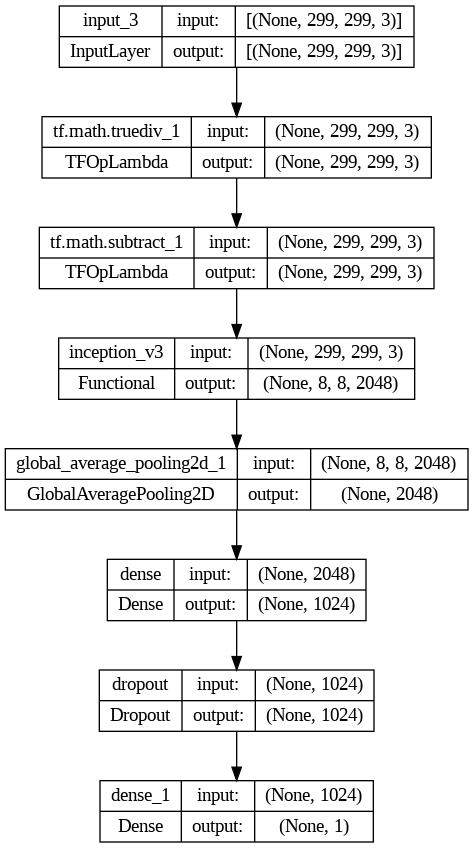

In [ ]:
# display model structure
plot_model(complex_model, 'inceptionV3_finetuning_complex_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="inceptionV3_finetuning_complex_model.png"))
!cp -r './inceptionV3_finetuning_complex_model.png' IMAGES_DIR_PATH

17/17 [==============================] - 16s 887ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.7921    0.7196    0.7541      2086
           1     0.7387    0.8076    0.7716      2048

    accuracy                         0.7632      4134
   macro avg     0.7654    0.7636    0.7629      4134
weighted avg     0.7656    0.7632    0.7628      4134



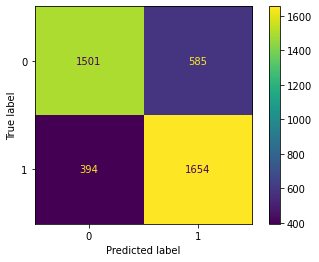

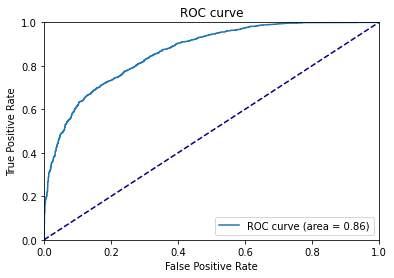

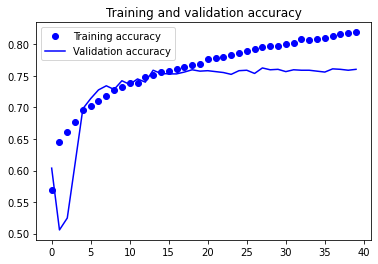

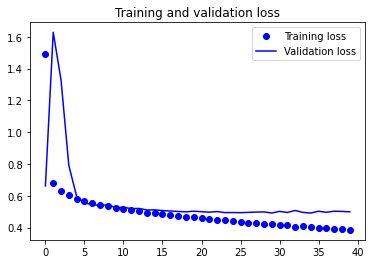

In [ ]:
# evaluate model
evaluate_model(complex_model, 'inceptionV3_finetuning_complex_model')
show_train_val_performance(history)